Para conseguir lidar com a analise de sentimentos no rosto humano será necessário utilizar a biblioteca TensorFlow com o ImageDataGenerator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Para conseguirmos lidar com nosso dataset teremos que definir os caminhos dele

In [16]:
dir_train = "../data/Fer2013Dataset/test"
dir_test = "../data/Fer2013Dataset/train"

# dir_train = "../data/FER2013Cleaned/test"
# dir_test = "../data/FER2013Cleaned/train"

Agora precisamos criar varaiveis que vão conter transformções que queremos aplicar em nossos datasets.

In [17]:
datagen_train = ImageDataGenerator(
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    validation_split = 0.2
)

datagen_test = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

Agora iremos carregar o caminho das imagens para poder preparar elas para treinamento em um modelo

In [19]:
train_generator = datagen_train.flow_from_directory(
    directory = dir_train,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "training"
)

validation_generator = datagen_train.flow_from_directory(
    directory = dir_test,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "validation"
)

Found 3328 images belonging to 5 classes.
Found 3332 images belonging to 5 classes.


Verificcando nossa base

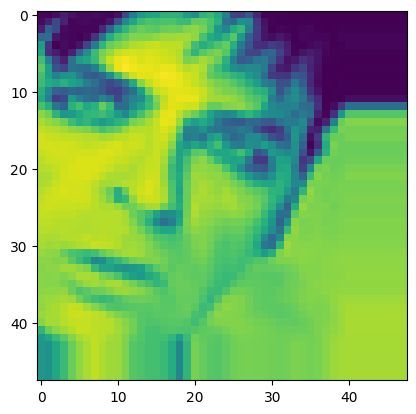

In [20]:
import matplotlib.pyplot as plt

for images, _ in train_generator:
    plt.imshow(images[0])
    plt.show()
    break

# Criando uma CNN para nossa aplicação
Agora que já cuidamos do preprocessamento das nossa imagens, podemos utilizá-las para treinar um modelo CNN. O que iremos utilizar será o mini_XCEPTION

In [21]:
input_shape = (48, 48, 1)
num_classes = 5
l2_regularization = 0.01
patience = 100

In [22]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, SeparableConv2D, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras import layers

In [23]:
regularization = l2(l2_regularization)

Primeiro aplicamos um entrada com o numero de pixels (48,48) e a escala (1), grayscale.

In [24]:
img_input = Input(input_shape)

Temos nossa primeira camada convolucional para nosso modelo

A bias é False, pois aplicamos a normalização na linha seguinte `BatchNormalization`.

In [25]:
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
            use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
            use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

Depois fazemos um loop de bloco para cada camada posterior. Está em loop, pois serão o mesmo bloco de comando e somente o valor do filtro mudará

In [26]:
filter_list = [16, 32, 64, 128]
for n in filter_list:
    residual = Conv2D(n, (1, 1), strides=(2, 2),
                        padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(n, (3, 3), padding='same',
                    depthwise_regularizer=regularization,
                    pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(n, (3, 3), padding='same',
                    depthwise_regularizer=regularization,
                    pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])



No fim, salvamos nosso modelo criado numa variável

In [27]:
x = Conv2D(num_classes, (3, 3),
            # kernel_regularizer=regularization,
            padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax', name='predictions')(x)

model = Model(img_input, output)

Resumo da arquitetura de rede feita para nosso modelo

In [28]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 46, 46, 8) │         72 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 46, 46, 8) │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 46, 46, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 44, 44, 8) │        576 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44, 8) │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 44, 44, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 44, 44,    │        200 │ activation_1[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 44, 44,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 44, 44,    │        400 │ activation_2[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 22, 22,    │        128 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 22, 22,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 22, 22,    │        656 │ add[0][0]         │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 56,117 (219.21 KB)

 Trainable params: 54,645 (213.46 KB)

 Non-trainable params: 1,472 (5.75 KB)

Compilando o modelo

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Agora iremos trainar nosso modelo com base nos preprocessamentos feitos

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [31]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=patience,   
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "melhor_modelo.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [32]:
hist = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100


c:\Users\gmara\Documents\Sourcetree\PhobiaScan\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2799 - loss: 5.6727
Epoch 1: val_accuracy improved from -inf to 0.23980, saving model to melhor_modelo.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 273ms/step - accuracy: 0.2804 - loss: 5.6653 - val_accuracy: 0.2398 - val_loss: 4.7925
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3379 - loss: 4.4078
Epoch 2: val_accuracy did not improve from 0.23980
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.3377 - loss: 4.4039 - val_accuracy: 0.2398 - val_loss: 3.9437
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3674 - loss: 3.6004
Epoch 3: val_accuracy did not improve from 0.23980
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.3673 - loss: 3.5974 - val_accuracy: 0.2398 - val_loss: 3.3989
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3684 - loss: 3.0419
Epoch 4: val_accuracy did not improve from 0.23980
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.3684 - loss:

Plotamos o gráfico de perda durante o treinamento

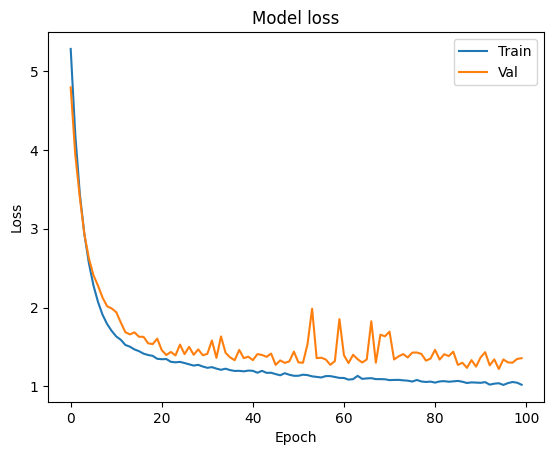

In [33]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

Plotamos o gráfico de acurácia durante o treinamento

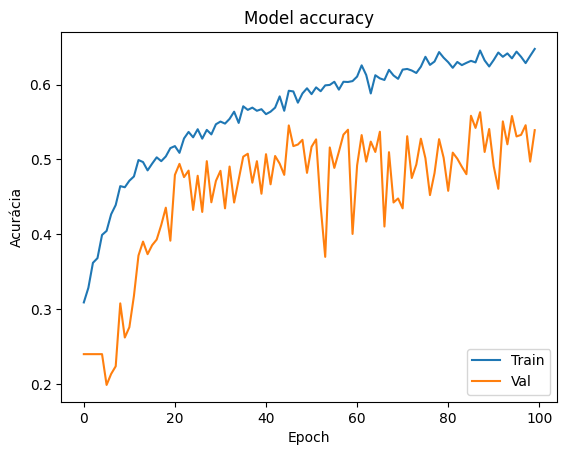

In [34]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


Salvamos nosso modelo

In [35]:
model.save("modelo_emocoes.keras")


Dessa forma, podemos agora sempre carregar nosso modelo para testar

In [36]:
from keras.models import load_model
model = load_model("modelo_emocoes.keras")


# Teste

Agora, podemos realizar testes para verificar se nosso modelo está reconhcendo ou não

(456, 292, 3)

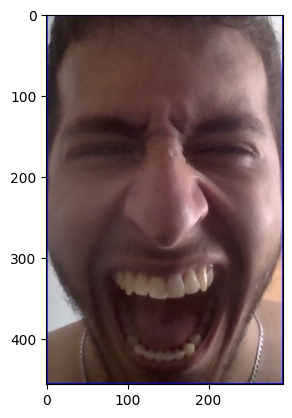

In [37]:
import matplotlib.pyplot as plt
# my_image = plt.imread("../data/FER2013Cleaned/test/fear/fer0000450.png")
my_image = plt.imread("../data/gab/Color/gab.153.jpg")
plt.imshow(my_image)
my_image.shape

Aplicamos transformações de tamanho para ficar no nosso padrão (48,48)

array([[[0.4158088 , 0.42466377, 0.82648417],
        [0.41088937, 0.41132935, 0.59024643],
        [0.17474808, 0.15075316, 0.33688845],
        ...,
        [0.64243334, 0.62769997, 0.79418066],
        [0.76839973, 0.76227674, 0.92327198],
        [0.70464131, 0.70159412, 0.92474937]],

       [[0.4670383 , 0.47388478, 0.75814665],
        [0.35594305, 0.34304467, 0.36354894],
        [0.18519076, 0.14233197, 0.15825854],
        ...,
        [0.62072891, 0.58995526, 0.5979139 ],
        [0.88431022, 0.87116364, 0.885106  ],
        [0.84688958, 0.83789981, 0.9275466 ]],

       [[0.41536863, 0.4066338 , 0.69488312],
        [0.26053332, 0.23174097, 0.24856559],
        [0.16845816, 0.1253612 , 0.12774134],
        ...,
        [0.49188728, 0.447723  , 0.4513558 ],
        [0.73709033, 0.71060064, 0.72276748],
        [0.80890178, 0.7933359 , 0.89147152]],

       ...,

       [[0.2898407 , 0.22944482, 0.47340978],
        [0.40399436, 0.32026465, 0.27100557],
        [0.40054843, 0

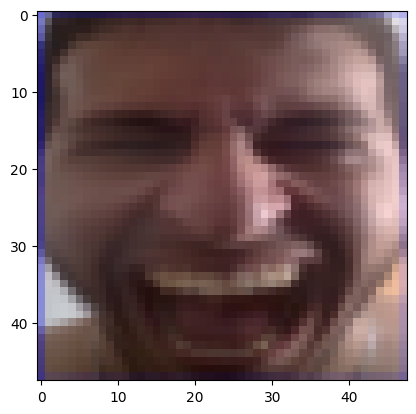

In [38]:
from skimage.transform import resize
my_image_resized = resize(my_image, (48,48,3))

img = plt.imshow(my_image_resized)
my_image_resized


Temos que aplicar uma transformação da imagem pro cinza, visto que treinamos um modelo com a escala cinza

In [39]:
import numpy as np
from skimage.color import rgb2gray

my_image_gray = rgb2gray(my_image_resized) 
my_image_gray = np.expand_dims(my_image_gray, axis=-1)  
my_image_gray = np.expand_dims(my_image_gray, axis=0)

probabilities = model.predict(my_image_gray)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


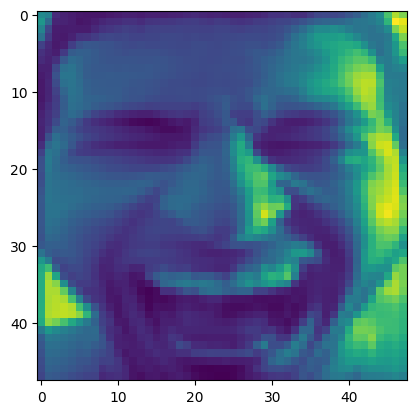

In [133]:
plt.imshow(np.squeeze(my_image_gray))
plt.show()

In [40]:
probabilities

array([[0.7615833 , 0.07320945, 0.12316819, 0.03938471, 0.00265437]],
      dtype=float32)

Por fim, verificamos as probabilidades de cada emoção

In [41]:
number_to_class = ['angry', 'disgust', 'fear', 'neutral', 'surprise']
index = np.argsort(probabilities[0,:])
print("Most likely class:", number_to_class[index[4]], "-- Probability:", probabilities[0,index[4]])
print("Second most likely class:", number_to_class[index[3]], "-- Probability:", probabilities[0,index[3]])
print("Third most likely class:", number_to_class[index[2]], "-- Probability:", probabilities[0,index[2]])
print("Fourth most likely class:", number_to_class[index[1]], "-- Probability:", probabilities[0,index[1]])
print("Fifth most likely class:", number_to_class[index[0]], "-- Probability:", probabilities[0,index[0]])

Most likely class: angry -- Probability: 0.7615833
Second most likely class: fear -- Probability: 0.123168185
Third most likely class: disgust -- Probability: 0.07320945
Fourth most likely class: neutral -- Probability: 0.03938471
Fifth most likely class: surprise -- Probability: 0.0026543664


In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Gere predições no conjunto de validação
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Matriz de confusão
print(confusion_matrix(validation_generator.classes, y_pred))

# Relatório por classe
print(classification_report(validation_generator.classes, y_pred,
                           target_names=number_to_class))

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
[[172   5 197 269 156]
 [ 19   1  18  32  17]
 [176   4 189 276 174]
 [222   1 222 352 196]
 [133   5 156 205 135]]
              precision    recall  f1-score   support

       angry       0.24      0.22      0.23       799
     disgust       0.06      0.01      0.02        87
        fear       0.24      0.23      0.24       819
     neutral       0.31      0.35      0.33       993
    surprise       0.20      0.21      0.21       634

    accuracy                           0.25      3332
   macro avg       0.21      0.20      0.20      3332
weighted avg       0.25      0.25      0.25      3332

